In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow.keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import losses, optimizers, metrics

from tensorflow.keras.callbacks import ModelCheckpoint 

from sklearn.metrics import confusion_matrix

from tensorflow.keras import backend as K

In [2]:
data = pd.read_csv('C:/Users/604070/Desktop/Files/Performance/OPM_HR_Analytics/Dataset/opm_raw.txt', low_memory=False)

In [3]:
def pre_process(df):
    
    data = df.iloc[:,2:]
    
    data.rename(columns = {'ACCT.1': 'quit_label'}, inplace=True)
    
    data['Year'] = data['EFDATET'].apply(lambda x: x[4:])
    data['Month'] = data['EFDATET'].apply(lambda x: x[:2])
    data['QTRT'] = data['QTRT'].apply(lambda x: x[:7])
    data['GSEGRD'] = data['GSEGRD'].astype(str)
    
    data.drop(['COUNT','EFDATET','FYT', 'OCCTYPT', 'LOS', 'SALARY'], axis=1, inplace=True)
    
    y = pd.get_dummies(data['quit_label'])
    
    data_dummy = pd.get_dummies(data[['AGELVLT', 'AGYSUBT', 'AGYT', 'AGYTYPT',
       'GSEGRD', 'LOCT', 'LOCTYPT', 'LOSLVLT', 'OCCFAMT', 'OCCT', 'PATCOT', 'PAYPLANT', 'PPGRD', 'PPGROUPT', 'QTRT',
       'SALLVLT', 'TOAT', 'TOATYPT', 'WORKSCHT', 'WSTYPT','Year', 'Month']]) 
       
    return data_dummy, y

In [4]:
X, y = pre_process(data)

In [5]:
X_base, X_test, y_base, y_test = train_test_split(X, y, test_size=0.1, random_state=305)

X_train, X_val, y_train, y_val = train_test_split(X_base, y_base, test_size=0.1, random_state=305)

In [14]:
# Model

model = Sequential()

# input/ hidden  

model.add(Dense(1400, input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(.2))

# hidden layer

model.add(Dense(700))
model.add(Activation('relu'))
model.add(Dropout(.2))

# hidden layer 

model.add(Dense(150))
model.add(Activation('relu'))
model.add(Dropout(.2))

# output layer 

model.add(Dense(2, activation='softmax'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1400)              1981000   
_________________________________________________________________
activation_3 (Activation)    (None, 1400)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1400)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 700)               980700    
_________________________________________________________________
activation_4 (Activation)    (None, 700)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 150)               105150    
__________

In [15]:
def precision(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    
    return precision


In [16]:
epochs = 25
batch_size = 100
learning_rate = .01

sgd = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9)

#categorical-cross entropy 

model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=[precision])

fitted_model = model.fit(X_train, y_train, 
              batch_size=batch_size,
              validation_data=(X_val, y_val), 
              epochs=epochs,
              #callbacks=[best_weights],
              verbose=1)

Train on 1679234 samples, validate on 186582 samples
Epoch 1/25
1679234/1679234 [==============================] - 650s 387us/step - loss: 0.3410 - precision: 0.8582 - val_loss: 0.3218 - val_precision: 0.8668
Epoch 2/25
1679234/1679234 [==============================] - 633s 377us/step - loss: 0.3238 - precision: 0.8657 - val_loss: 0.3194 - val_precision: 0.8675
Epoch 3/25
1679234/1679234 [==============================] - 625s 372us/step - loss: 0.3171 - precision: 0.8688 - val_loss: 0.3112 - val_precision: 0.8708
Epoch 4/25
1679234/1679234 [==============================] - 623s 371us/step - loss: 0.3123 - precision: 0.8710 - val_loss: 0.3084 - val_precision: 0.8729
Epoch 5/25
1679234/1679234 [==============================] - 623s 371us/step - loss: 0.3084 - precision: 0.8726 - val_loss: 0.3063 - val_precision: 0.8732
Epoch 6/25
1679234/1679234 [==============================] - 620s 369us/step - loss: 0.3053 - precision: 0.8741 - val_loss: 0.3060 - val_precision: 0.8748
Epoch 7/25


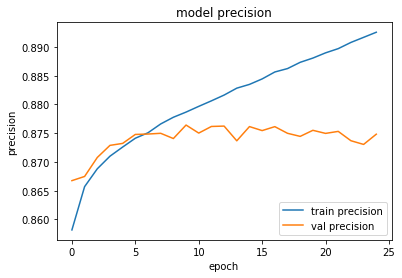

In [17]:
# precision plot
#fitted_model.history

plt.plot(fitted_model.history['precision'])
plt.plot(fitted_model.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train precision', 'val precision'], loc='lower right')
plt.show()


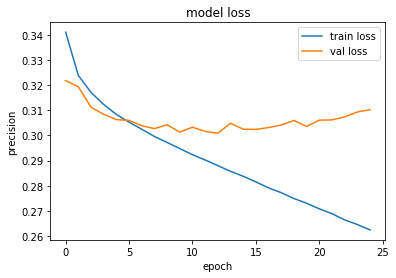

In [18]:
plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper right')
plt.show()

In [19]:
predictions = model.predict(X_test)

In [20]:
conf_table = confusion_matrix(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis = 1))

Accuracy... 87.32351565024867
Precision... 70.32340789286224
[[166225   6249]
 [ 20031  14808]]


<Figure size 432x288 with 0 Axes>

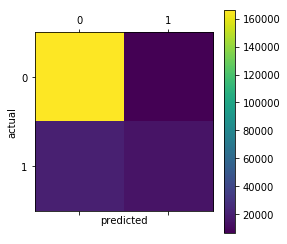

In [21]:
plt.figure()

tn, fp, fn, tp = confusion_matrix(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis = 1)).ravel()

print('Accuracy...', (tn + tp) / (tn + fp + fn + tp) * 100)

print('Precision...', (tp) / (fp + tp) * 100)

print(conf_table)

plt.colorbar(plt.matshow(conf_table))

plt.ylabel('actual')
plt.xlabel('predicted')


plt.show()